In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../..")

import numpy as np
import pandas as pd
import h5py
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pyBigWig

from basenji import dataset
from utils.call_peaks import call_peaks

In [3]:
root_dir = "/clusterfs/nilah/pooja"
fig_dir = f"{root_dir}/CellTypeSpecificAccessibilityPrediction/figures"

In [4]:
data_dir = "/clusterfs/nilah/richard/basenji2/data_pretrained_basenji2/human"
bigwig_dir = "/global/scratch/users/poojakathail/enformer/peak_experimental_reproducibility/encode_bigwigs"

human_targets = pd.read_csv(f"{data_dir}/targets.txt", sep="\t", index_col=0)
dnase_atac_targets = np.where([("DNASE" in i) or ("ATAC" in i) 
                               for i in human_targets["description"]])[0]

In [27]:
sequences = pd.read_csv(f"{data_dir}/sequences.bed", sep="\t",
                        names=["chr", "start", "end", "fold"])
sequences = sequences[sequences["fold"] == "test"]
sequences["bins"] = sequences.apply(lambda x: np.array([(x.chr, x.start + 8192 + (128*i), x.start + 8192 + (128*(i+1))) for i in range(896)]), axis=1)
sequence_bins = np.stack(sequences["bins"].values)                                              

In [28]:
corrs = pd.read_csv(f"{fig_dir}/fig2/enformer_reference_accuracy_cell_type_specific_bins.csv",
                    index_col=0)
num_peaks = pd.read_csv(f"{fig_dir}/fig2/enformer_num_peaks_in_cell_type_specific_bins.csv",
                        index_col=0)

targets_with_most_peaks = num_peaks.min(axis=1).sort_values(ascending=False)[:20].index.values
# only kept one ATAC track (681, but can't find raw data)
# removed 183,529,19,402 bc not isogenic replicates
# removed 625 bc its archived and can't find the bigwigs on ENCODE website

selected_targets = [135,144,79,112,96] 

In [29]:
# read in targets
eval_data = dataset.SeqDataset(data_dir,
    split_label="test",
    batch_size=4,
    mode='eval',
    tfr_pattern=None,
    float_type="float16")
targets = eval_data.numpy(return_inputs=False, return_outputs=True)

test_targets_dnase_ds = targets[:, :, dnase_atac_targets].reshape(-1,len(dnase_atac_targets))
sequence_bins_ds = sequence_bins.reshape(-1, 3)
assert test_targets_dnase_ds.shape[0] == sequence_bins_ds.shape[0]

In [30]:
if not os.path.exists(f"{bigwig_dir}/ti_{selected_targets[0]}_peak_targets.h5"):
    print("calling peaks..")
    test_targets_dnase_ds_peaks = call_peaks(test_targets_dnase_ds, return_full=True)
    peak_in_num_cell_types = test_targets_dnase_ds_peaks.sum(axis=1)

    bins = [(1, 10), (10, 50), (50, 100), 
            (100, 300), (300, 685)]
    
    # save bin indices for each target
    for ti in tqdm(selected_targets):
        target_inds_h5 = h5py.File(f"{bigwig_dir}/ti_{ti}_peak_targets.h5", 'w')

        for (bin_min, bin_max) in bins:   
            bin_inds = np.where((test_targets_dnase_ds_peaks[:,ti] == True) &
                                (test_targets_dnase_ds_peaks.sum(axis=1) >= bin_min) &
                                (test_targets_dnase_ds_peaks.sum(axis=1) < bin_max))[0]
            target_inds_h5.create_dataset(f'{bin_min}-{bin_max}', data=bin_inds, dtype='int', compression='gzip')
        target_inds_h5.close()
else:
    target_inds = {}
    for ti in selected_targets:
        target_inds[ti] = h5py.File(f"{bigwig_dir}/ti_{ti}_peak_targets.h5", 'r')

In [74]:
%%bash

export BASENJIDIR=/global/home/users/poojakathail/basenji
export PATH=$BASENJIDIR/bin:$PATH
export PYTHONPATH=$BASENJIDIR/bin:$PYTHONPATH

bigwig_dir="/global/scratch/users/poojakathail/enformer/peak_experimental_reproducibility/encode_bigwigs"
blacklist_bed="/clusterfs/nilah/pooja/genomes/hg38.blacklist.rep.bed"
seq_bed="/clusterfs/nilah/richard/basenji2/data_pretrained_basenji2/human/sequences.bed"

for ti in 135 144 79 112 96;
do
    for encode_id in `ls -1 ${bigwig_dir}/ti_${ti}/*.bigWig | cut -d '/' -f 10 | cut -d '.' -f 1`;
    do
        bigwig_file="${bigwig_dir}/ti_${ti}/${encode_id}.bigWig"
        h5_out="${bigwig_dir}/ti_${ti}/${encode_id}.h5"
        echo "python /global/home/users/poojakathail/basenji/bin/basenji_data_read.py --clip_soft 32 -s 2 -b ${blacklist_bed} --crop 8192 -u mean -w 128 ${bigwig_file} ${seq_bed} ${h5_out}"
    done
done

python /global/home/users/poojakathail/basenji/bin/basenji_data_read.py --clip_soft 32 -s 2 -b /clusterfs/nilah/pooja/genomes/hg38.blacklist.rep.bed --crop 8192 -u mean -w 128 /global/scratch/users/poojakathail/enformer/peak_experimental_reproducibility/encode_bigwigs/ti_135/ENCFF241ZSS.bigWig /clusterfs/nilah/richard/basenji2/data_pretrained_basenji2/human/sequences.bed /global/scratch/users/poojakathail/enformer/peak_experimental_reproducibility/encode_bigwigs/ti_135/ENCFF241ZSS.h5
python /global/home/users/poojakathail/basenji/bin/basenji_data_read.py --clip_soft 32 -s 2 -b /clusterfs/nilah/pooja/genomes/hg38.blacklist.rep.bed --crop 8192 -u mean -w 128 /global/scratch/users/poojakathail/enformer/peak_experimental_reproducibility/encode_bigwigs/ti_135/ENCFF302JEV.bigWig /clusterfs/nilah/richard/basenji2/data_pretrained_basenji2/human/sequences.bed /global/scratch/users/poojakathail/enformer/peak_experimental_reproducibility/encode_bigwigs/ti_135/ENCFF302JEV.h5
python /global/home/us

In [31]:
peak_experimental_reproducibility_df = pd.DataFrame([])

for ti in selected_targets:
    encode_ids = os.listdir(f"{bigwig_dir}/ti_{ti}")
    encode_ids = np.unique([f.split(".")[0] for f in encode_ids])
    for encode_id in encode_ids:
        h5_file = f"{bigwig_dir}/ti_{ti}/{encode_id}.h5"
        targets_h5 = h5py.File(h5_file, "r")
        bigwig_targets = targets_h5["targets"][sequences.index.values,:].reshape(-1).astype(np.float16)
        bigwig_targets_peaks = call_peaks(bigwig_targets.reshape(-1,1), return_full=True).flatten()
        
        
        for bin_ in target_inds[ti].keys():
            bin_formatted = f"({bin_.split('-')[0]}, {bin_.split('-')[1]})"
            bin_targets = target_inds[ti][bin_][:]            
            proportion_replicating_peaks = bigwig_targets_peaks[bin_targets].sum()/len(bin_targets)

            peak_experimental_reproducibility_df = peak_experimental_reproducibility_df.append(
                {"Target index": ti,
                 "ENCODE ID": encode_id,
                 "Data type": "Enformer training data" if encode_id == human_targets.loc[ti, "identifier"] else "Isogenic replicate",
                 "Bin": bin_formatted,
                 "Proportion replicating peaks": proportion_replicating_peaks,
                 "Pearson R": stats.pearsonr(test_targets_dnase_ds[bin_targets,ti], 
                                             bigwig_targets[bin_targets])[0]},
                ignore_index=True)

In [32]:
tmp_df = pd.melt(corrs.loc[selected_targets], var_name="Bin", value_name="Pearson R")
tmp_df["Data type"] = "Enformer predictions"
peak_experimental_reproducibility_df = pd.concat([peak_experimental_reproducibility_df, tmp_df])

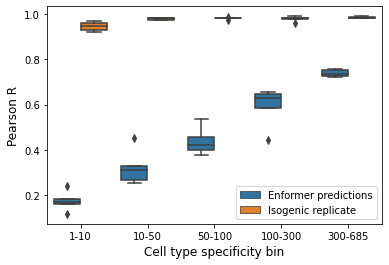

In [37]:
sns.boxplot(data=peak_experimental_reproducibility_df, 
            x="Bin", y="Pearson R", hue="Data type", 
            hue_order=["Enformer predictions", "Isogenic replicate"],
            order=["(1, 10)", "(10, 50)", "(50, 100)", "(100, 300)", "(300, 685)"],)
plt.ylabel("Pearson R", fontsize=12)
plt.xlabel("Cell type specificity bin", fontsize=12)
_, _ = plt.xticks(np.arange(5), ["1-10", "10-50", "50-100", "100-300", "300-685"])
plt.legend()
plt.savefig(f"{fig_dir}/supp_figs/enformer_prediction_replicate_comparison.pdf", dpi=300)